In [7]:
import os
import glob
import torchvision
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

if "script" in os.getcwd():
    os.chdir("..")
os.getcwd()

import sys
import time
import warnings

warnings.filterwarnings("ignore")

import yaml
import torch
import numpy as np

from src.logger.logger import configure_logging
from src.model.utils import get_model
from src.dataset.noisemap import NoiseMapTestPhase


def read_npy(path: str):
    with open(path, "rb") as f:
        a = np.load(f)
        a = a / np.max(a) * 255
    return a


def show_im(im, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    if isinstance(im, list):
        plt.imshow(np.hstack([i for i in im]), cmap="gray")
    else:
        plt.imshow(im, cmap="gray")
    plt.show()


def show_multi_im(imgs: list, ratio=(5, 12), figsize=(20, 10)):
    index = 0
    f, axarr = plt.subplots(ratio[0], ratio[1], figsize=figsize)
    for r in range(ratio[0]):
        for c in range(ratio[1]):
            axarr[r, c].imshow(imgs[index], cmap="gray")
            index += 1
    plt.show()


def get_infor(data, lib="torch"):
    lib = torch if lib == "torch" else np
    return f"Max: {lib.max(data)} - Min: {lib.min(data)}"


def make_dir(config, layer):
    condition = f"{config['clip']}clip_{config['normalize']}normalize_sigrange{config['sigma_range']}_{config['output_mode']}"
    save_dir = f"report/images/layers_{config['model_name']}{layer}_{condition}"
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join("report", "images"), exist_ok=True)
    return save_dir

In [8]:
torch.manual_seed(1234)
np.random.seed(1234)

logger = configure_logging()

ValueError: There is no existing handler with id 0

In [9]:
with open(f"config/train_subnet_config.yml") as f:
    config = yaml.safe_load(f)

config['weight'] = "result/layers_fcn5_Falseclip_Truenormalize_sigrange10_55_image_1_5e-05/model_006.pth"

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Device : {device}")

2023-03-30 22:08 | [INFO] __main__:<module>:8 : Device : cuda:0 


In [10]:
model = get_model(
    name=config["model_name"],
    layers=config["layers"],
    input_channels=config["channels"],
    feature=config["features"],
)
logger.info(os.getcwd())
model.eval()
check_point = torch.load(config["weight"])
model.load_state_dict(check_point)

if cuda:
    model = model.cuda()

2023-03-30 22:08 | [INFO] __main__:<module>:7 : /media/nguyen/SamsungSSD/Thacsi/Master_Course/ImageDenoise 


In [11]:


phase = "test"
sigma = 35

data = glob.glob(f"{config['data_dir']}/{phase}/sigma_{sigma}/*.npy")
transform = torchvision.transforms.ToTensor()
save_dir = make_dir(config, layer=config["layers"])


2023-03-30 22:08 | [SUCCESS] src.dataset.noisemap:__init__:46 : test subnet with - sigma: 10 - noise_mode: rice 
2023-03-30 22:08 | [SUCCESS] src.dataset.noisemap:__init__:46 : test subnet with - sigma: 25 - noise_mode: rice 
2023-03-30 22:08 | [SUCCESS] src.dataset.noisemap:__init__:46 : test subnet with - sigma: 35 - noise_mode: rice 
2023-03-30 22:08 | [SUCCESS] src.dataset.noisemap:__init__:46 : test subnet with - sigma: 45 - noise_mode: rice 
2023-03-30 22:08 | [SUCCESS] src.dataset.noisemap:__init__:46 : test subnet with - sigma: 55 - noise_mode: rice 


Sigma: 10
Max: 24.576568603515625 - Min: -8.029935836791992


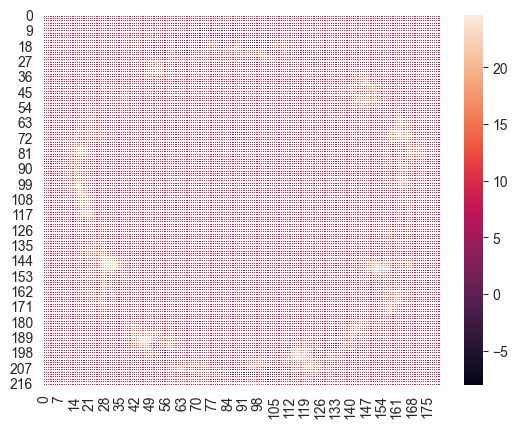

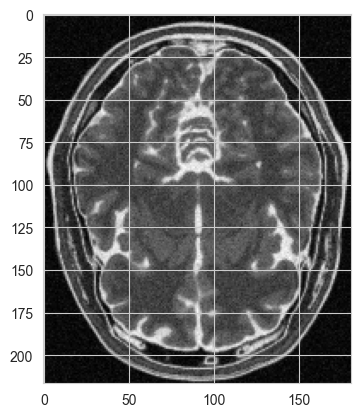

2023-03-30 22:08 | [INFO] __main__:<module>:41 : sigma 10: 2.6182 


Sigma: 25
Max: 42.90055847167969 - Min: 4.083294868469238


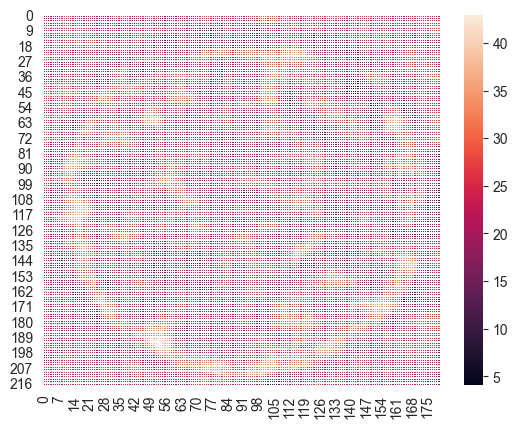

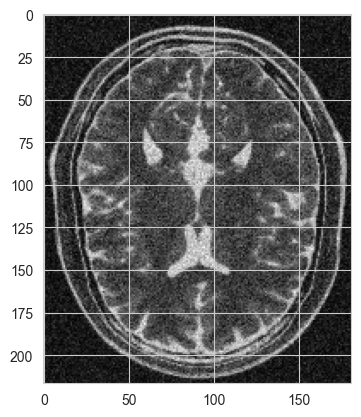

2023-03-30 22:08 | [INFO] __main__:<module>:41 : sigma 25: 17.4689 


Sigma: 35
Max: 53.911170959472656 - Min: 9.620545387268066


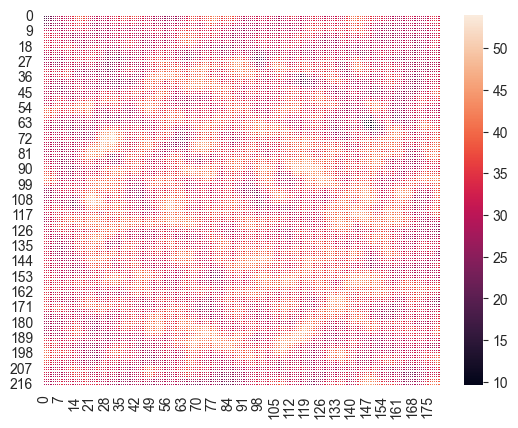

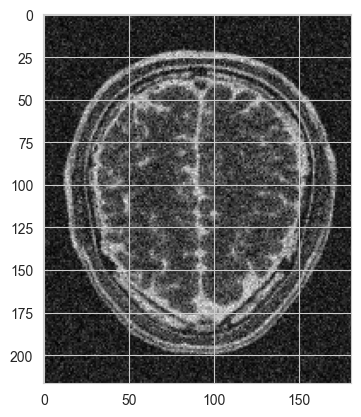

2023-03-30 22:08 | [INFO] __main__:<module>:41 : sigma 35: 21.6476 


Sigma: 45
Max: 57.1634407043457 - Min: 24.828922271728516


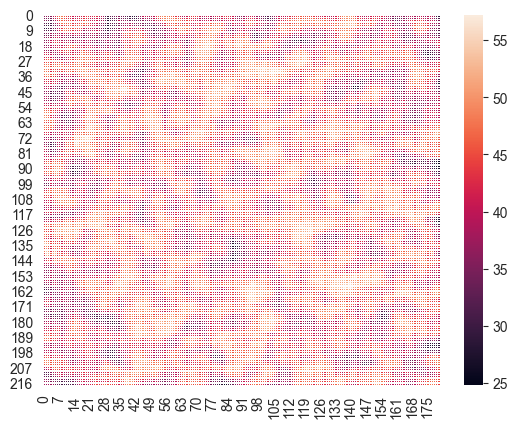

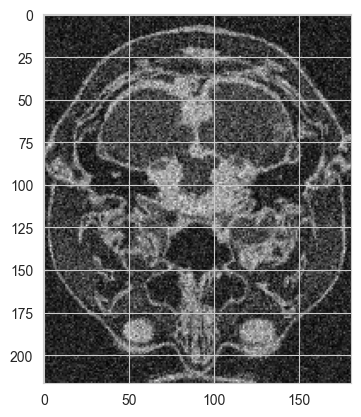

2023-03-30 22:08 | [INFO] __main__:<module>:41 : sigma 45: 26.0939 


Sigma: 55
Max: 62.50351333618164 - Min: 27.18532371520996


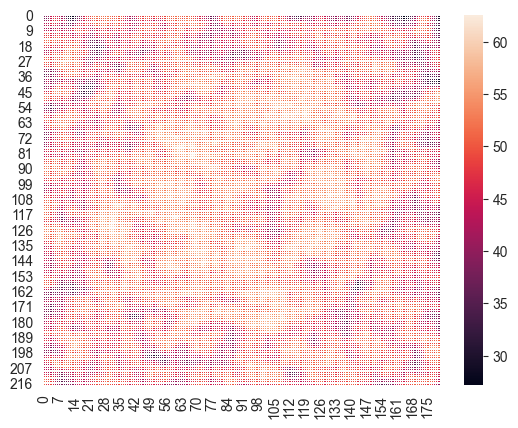

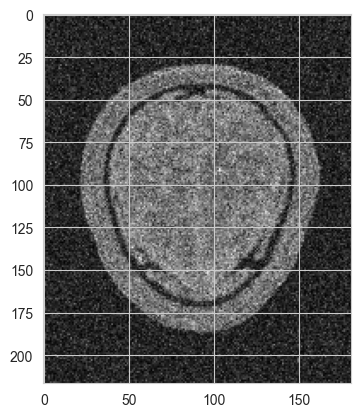

2023-03-30 22:08 | [INFO] __main__:<module>:41 : sigma 55: 64.0034 


In [13]:
test_phase = NoiseMapTestPhase(
        data_dir=config.get('data_dir', 'data'),
        range_sigma=config["sigma_range"],
        step=5,
        n_workers=0,
        batch_size=1,
        log_dir=f"{save_dir}_test",
        normalize=config["normalize"],
        clip=config["clip"],
        device=device,
        noise_mode=config.get('noise_mode', 'rice')
    )
for sigma in config["sigma_range"]:
    mse = []
    for i, data in enumerate(test_phase.dataloader[sigma]):

        noisy_imgs, gt_noisemap = data[0].to(test_phase.device), data[1].to(test_phase.device)

        predicted = model(noisy_imgs)
        print('=======================================')

        if config["normalize"]:
            noisy_imgs = noisy_imgs * 255
            predicted = predicted * 255
            gt_noisemap = gt_noisemap * 255
        if config["clip"]:
            noisy_imgs = noisy_imgs.clamp(0, 255)
            predicted = predicted.clamp(0, 255)
            gt_noisemap = gt_noisemap.clamp(0, 255)
        mse.append(torch.mean(torch.square(predicted - gt_noisemap).cpu().detach()).item())
        print(f"Sigma: {sigma}")
        print(get_infor(predicted))
        ax = sns.heatmap(predicted.squeeze(0).squeeze(0).cpu().detach().numpy(), linewidth=0.5)
        plt.show()
        noisy_imgs = noisy_imgs.squeeze(0).squeeze(0).cpu().detach().numpy()
        plt.imshow(((noisy_imgs/np.max(noisy_imgs)) * 255).clip(0,255).astype(np.uint8), cmap='gray')
        plt.show()

        print('=======================================')
        break
    logger.info(f"sigma {sigma}: {round(sum(mse)/len(mse), 4)}")




In [ ]:
import pandas as pd

phase = "test"
sigma = 45
num_samples = 10


def make_noised_img(img, sigma=sigma, noise_mode=config['noise_mode']):
    # Noise
    if noise_mode == 'rice':
        noise1 = np.random.randn(img.shape[0], img.shape[1]) * sigma
        noise2 = np.random.randn(img.shape[0], img.shape[1]) * sigma
        return np.sqrt((img + noise1) * (img + noise1) + noise2 * noise2)
    elif noise_mode == 'gausse':
        noise1 = np.random.randn(img.shape[0], img.shape[1]) * sigma
        return img + noise1


data = glob.glob(f"{config['data_dir']}/{phase}/origin/*.npy")
print(f"Number images of sigma {sigma}: {len(data)}")

for image_path in random.sample(data, num_samples):
    origin = read_npy(image_path)
    noised_im = make_noised_img(origin, sigma=sigma)
    noised_im_tensor = transform(noised_im.astype(np.int32)).float()

    if config['clip']:
        noised_im_tensor = noised_im_tensor.clamp(0,255)
    if config['normalize']:
        noised_im_tensor = noised_im_tensor.div(255)

    predicted = model(noisy_imgs.to(device))

    if config["normalize"]:
        predicted = predicted * 255
        gt_noisemap = gt_noisemap * 255
    if config["clip"]:
        predicted = predicted.clamp(0, 255)
        gt_noisemap = gt_noisemap.clamp(0, 255)
    print(get_infor(predicted))
    mse.append(torch.mean(torch.square(predicted - gt_noisemap).cpu().detach()).item())
logger.info(f"sigma {sigma}: {round(sum(mse)/len(mse), 4)}")
